In [1]:
 %reload_ext autoreload

In [2]:
%autoreload

from model.base import Base
from model.head import Head
import torch
import h5py
import numpy as np
import os
from utils import build_h5,extract_features, get_model_from_ckpt,train,eval,lr_rescheduler, makedirs,save_model,logging
from torch.optim import Adam
import gc
from dataloader import get_dataloader
from model.finetune_model import Fmodel
from torchsummary import summary
torch.cuda.set_per_process_memory_fraction(0.5, 0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

hard_dp = False
if hard_dp:
    dropout = [0.5,0.5,0.75]
else:
    dropout = [0.25,0.25,0.5]

base_model_type = 'inceptionv3'
num_level = 11
feature_type = 'narrow'
head_type = 'multi_3FC'
if feature_type == 'wide':
    head_type = 'pool_3FC'
    
root = './experiment/'
resize = True
augment = False
n_aug = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ckpt_folder,fea_folder = makedirs(root,base_model_type,num_level,feature_type,head_type,resize,augment,hard_dp)
h5_paths = [os.path.join(os.path.split(fea_folder)[0] if split!='train' else fea_folder, split + '_fea.h5') for split in ['train', 'val', 'test']]
train_batch_size = 1
fealoaders = get_dataloader(data_type='fea', head_type = head_type, resize = resize, augment= augment, h5_paths = h5_paths, batch_size = train_batch_size)

In [4]:
a = iter(fealoaders[0])
b,c = a.next()
b = b.detach().numpy()
bs = 1
for i in range(len(fealoaders[0].dataset)):
    c,d = a.next()
    c = c.detach().numpy()
    if (c==a).all():
        print('found')
    


In [9]:
%autoreload
from dataloader import get_dataloader
extract_batch_size = 1

imgloaders = get_dataloader(data_type='img',resize=resize,augment=augment,finetune=True,\
                            batch_size = extract_batch_size, head_type = head_type)
a = iter(imgloaders[0])
b,c = a.next()


1000.jpg MOS    5.58
Name: 1000, dtype: float64
10002.jpg MOS    4.243386
Name: 10002, dtype: float64
10000.jpg MOS    5.053763
Name: 10000, dtype: float64
10005.jpg MOS    5.411111
Name: 10005, dtype: float64
10003.jpg MOS    6.068182
Name: 10003, dtype: float64


In [12]:
df.loc[10002]

MOS    4.243386
Name: 10002, dtype: float64

In [ ]:
import matplotlib.pyplot as plt

# %autoreload
# from dataloader import ImgDataset
# a = ImgDataset('./data/', 'train' , True, True, False)
# b = iter(a)
# feature, label = next(b)


1000.jpg


'for batch, (feature, label) in enumerate(imgloaders[2]):\n    plt.imshow(np.moveaxis(feature[0].numpy(),0,-1))\n    plt.show()\n    print(label[0])'

10007.jpg


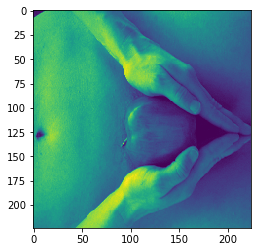

tensor(5.8876, dtype=torch.float64)


In [ ]:
import numpy as np
feature, label = next(b)
plt.imshow(np.moveaxis(feature[0].numpy(),0,-1))
plt.show()
print(label[0])

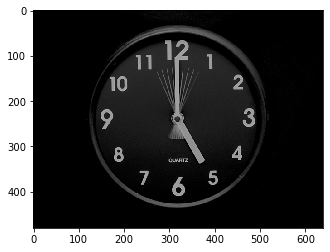

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
a = Image.open('./imgs/images/1006.jpg').convert("RGB")
plt.imshow(a)
plt.show()

In [5]:
import pandas as pd

df = pd.read_csv('./data/AVA.txt', header = None, delimiter = '\s+')
df.drop(columns = [0,12,13,14],inplace=True)
df['count'] = df.iloc[:,1:].sum(axis=1)
for i in range(2,12):
    df[i] = df[i]*(i-1)
df['MOS'] = df.iloc[:,1:-1].sum(axis=1)/df['count']
df.rename(columns = {1:'img'},inplace=True)
df.loc[(df.img==954113)]
df.set_index('img',inplace=True)
df.drop(columns = df.columns[:-1],inplace=True)
#df.to_csv('./data/label.csv')

In [ ]:
df.loc[df.MOS == df.MOS.max()]
df.loc[900]

MOS    5.688776
Name: 900, dtype: float64

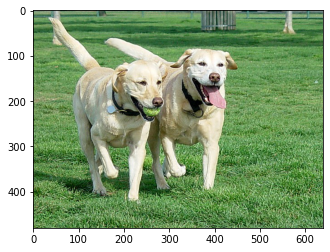

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

plt.imshow(Image.open('/content/images/900.jpg'))
plt.show()

In [ ]:
%cd F:\DA\SRP\AestheticPredictionMLSP

F:\DA\SRP\AestheticPredictionMLSP


In [1]:
from model.base import Base
from model.head import Head
import torch
import h5py
import numpy as np
import os
from utils import build_h5,extract_features, get_model_from_ckpt,train,eval,lr_rescheduler, makedirs,save_model,logging
from torch.optim import Adam
import gc
from dataloader import get_dataloader
import matplotlib.pyplot as plt
from PIL import Image
import os
from model.finetune_model import Fmodel
import pandas as pd

hard_dp = False
if hard_dp:
    dropout = [0.5,0.5,0.75]
else:
    dropout = [0.25,0.25,0.5]

base_model_type = 'inceptionv3'
num_level = 11
feature_type = 'narrow'
head_type = 'single_1FC'
if feature_type == 'wide':
    head_type = 'pool_3FC'
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
bmodel = Base(model = base_model_type, level = num_level)

head = Head(head_type,bmodel.channel_size,dropout)
head,_,_,_,_,_ = get_model_from_ckpt(model = head,
    ckpt = 'experiment/inceptionv3/11/narrow/single_1FC/resize/head_ep26_vloss0.34_plcc0.60_srcc0.57_acc0.78_.pth')
fmodel = Fmodel(base_model_type,feature_type, head, num_level, bmodel)
fmodel.to(device)
fmodel.eval()

df = pd.read_csv('./data/label.csv').set_index('img')


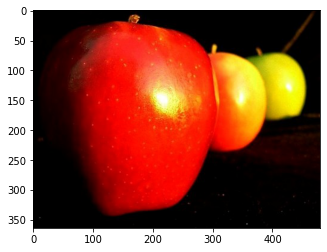

pred:  tensor([4.5235], device='cuda:0', grad_fn=<SelectBackward>)  , label:  4.324675324675325


In [7]:
import torchvision.transforms as T
from torchvision.transforms.functional import five_crop,crop,resize,hflip,normalize

img = Image.open('/content/images/179045.jpg')
label = df.loc[179045]

plt.imshow(img)
plt.show()

if len(img.size)==2:
    img = img.convert('RGB')
img = T.ToTensor()(img)
img = normalize(img,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img = torch.unsqueeze(img,0)
img =img.to(device)
pred = fmodel(img)
print('pred: ', pred[0], ' , label: ', label[0])

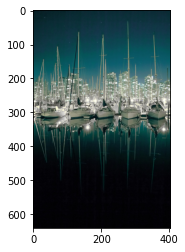

pred:  tensor([4.8454], device='cuda:0', grad_fn=<SelectBackward>)  , label:  7.127572016460905


In [10]:
label = df.loc[106]
img = Image.open('/content/images/10.jpg')

plt.imshow(img)
plt.show()

if len(img.size)==2:
    img = img.convert('RGB')
img = T.ToTensor()(img)
img = normalize(img,mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img = torch.unsqueeze(img,0)
img =img.to(device)
pred = fmodel(img)
print('pred: ', pred[0], ' , label: ', label[0])

In [1]:
import pandas as pd

mode = 'val'
df = pd.read_csv('./data/AVA_data_official_test.csv')


In [2]:
df['set'] = df['set'].map({'training':'train','validation':'val','test':'test'})
df.to_csv('./data/AVA_data_official_test.csv')
df.head()

,1,2,3,4,5,6,7,8,9,10,tag1,tag2,challenge_id,MOS,image_name,MLS,set,width,height
0,0,0,0,5,32,50,23,10,3,1,22,0,1396,6.112903,953417.jpg,6,train,781.0,699.0
1,0,3,2,3,13,40,35,21,8,3,20,53,1396,6.593750,953777.jpg,6,train,550.0,800.0
2,0,2,3,9,35,50,20,5,2,2,0,0,1396,5.796875,953756.jpg,6,train,800.0,594.0
3,0,1,7,26,56,23,6,1,0,2,0,0,1396,5.040984,954195.jpg,5,train,587.0,674.0
4,0,1,4,5,33,50,17,9,3,2,21,28,1396,5.943548,953903.jpg,6,train,800.0,533.0


In [3]:
df.set.unique()

array(['train', 'val', 'test'], dtype=object)